In [41]:
%matplotlib inline

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.3.0


##Importing the Data

In [2]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)


In [3]:
#reshape and normalizing the values

x_train = np.reshape(x_train , (60000, 784)) / 255.

x_test = np.reshape(x_test , (10000, 784)) / 255.

In [4]:
print(x_train.shape , x_test.shape)

(60000, 784) (10000, 784)


##Plotting the triplets

In [5]:
def plot_triplet(triplet):
  plt.figure(figsize= (6,2))
  for i in range(0,3):
    plt.subplot(1 , 3 ,i+1)
    plt.imshow(np.reshape(triplet[i] , (28 ,28) ) , cmap = 'binary' )
    plt.xticks([])
    plt.yticks([])
  plt.show()

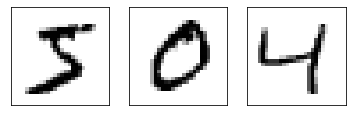

In [6]:
plot_triplet([x_train[0] , x_train[1] , x_train[2]])

##Creating Batch of triplets

In [7]:
 def create_batch(batch_size):

   #place holders
   anchor = np.zeros((batch_size , 784))
   positive = np.zeros((batch_size , 784))
   negative = np.zeros((batch_size , 784))

   for i in range(batch_size):
     index = np.random.randint(0 , 60000) #randomly selected an image
     anc = x_train[index]
     y = y_train[index]

     
     indices_for_pos = np.squeeze( np.where( y_train == y ) )
     indices_for_neg = np.squeeze( np.where( y_train != y ) )

     pos = x_train[indices_for_pos[random.randint( 0 , len(indices_for_pos) -1 )]]
     neg = x_train[indices_for_neg[random.randint( 0 , len(indices_for_neg) -1 )]]

     anchor[i] = anc
     positive[i] = pos
     negative[i] = neg

   return([anchor , positive , negative])

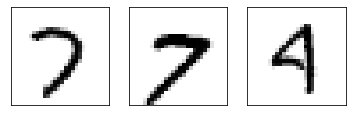

In [8]:
triplet = create_batch(1)
plot_triplet(triplet)

##Embedding Model

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense , Input , concatenate

In [10]:
emb_dim = 32

embedding_model = Sequential([
                  Dense(512 , activation= 'relu' , input_shape = ( 784,)) ,
                  Dense(128 , activation = 'relu') ,
                  Dense(emb_dim , activation= 'sigmoid' )
])

embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
Total params: 471,712
Trainable params: 471,712
Non-trainable params: 0
_________________________________________________________________


In [11]:
example = x_train[0]
example_emb = embedding_model.predict(np.expand_dims(example , axis =0))[0]

print(example_emb)

[0.54803306 0.53108805 0.49562532 0.6386237  0.5025602  0.5471659
 0.40313032 0.5611406  0.58900785 0.43523338 0.5275024  0.57634175
 0.63048536 0.67789096 0.41902032 0.5281969  0.4446585  0.62487185
 0.48857415 0.58464205 0.41222435 0.50335234 0.49861407 0.63579166
 0.5136477  0.4269787  0.56427246 0.5800411  0.5165043  0.4932741
 0.42963547 0.6229909 ]


##Siamese Network

In [12]:
in_anc = Input(shape =(784 ,))
in_pos = Input(shape =(784 ,))
in_neg = Input(shape =(784 ,))


em_anc = embedding_model(in_anc)
em_pos = embedding_model(in_pos)
em_neg = embedding_model(in_neg)

out = concatenate([em_anc , em_pos , em_neg] , axis = 1)

net = keras.models.Model(
        [in_anc , in_pos , in_neg] ,
        out
)
net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32)           471712      input_1[0][0]                    
                                                                 input_2[0][0]         

##Triple Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [28]:
#https://datascience.stackexchange.com/questions/25029/custom-loss-function-with-additional-parameter-in-keras

def triplet_loss(alpha , emb_dim):
  def loss(y_true , y_pred):
    anc , pos , neg = y_pred[ : , : emb_dim] , y_pred[ : ,emb_dim: 2*emb_dim ] , y_pred[ : , 2* emb_dim : ]  
    dp = tf.reduce_mean(tf.square(anc - pos ) , axis =1)
    dn = tf.reduce_mean(tf.square(anc - neg ) , axis =1)
    return tf.maximum(dp - dn + alpha , 0. )
  return loss

##Data Generator

In [21]:
def data_generator(batch_size , emb_dim):
  while True:
    x = create_batch(batch_size)
    y = np.zeros((batch_size , 3 * emb_dim)) #we need to pass y even though its not needed
    yield x ,y 
  

##Training the model

In [29]:
batch_size = 1024
epochs = 25
 
steps_per_epoch = (60000 / batch_size)

net.compile(loss = triplet_loss(0.2 , emb_dim) , optimizer = 'adam')

X,Y = x_test[:1000] , y_test[:1000]

In [30]:
net.fit(
    data_generator(batch_size , emb_dim) ,
    epochs = epochs , steps_per_epoch = steps_per_epoch,
    
)

Epoch 1/25
59/58 [==============================] - 33s 555ms/step - loss: 0.0683
Epoch 2/25
59/58 [==============================] - 33s 553ms/step - loss: 0.0268
Epoch 3/25
59/58 [==============================] - 33s 557ms/step - loss: 0.0176
Epoch 4/25
59/58 [==============================] - 33s 556ms/step - loss: 0.0124
Epoch 5/25
59/58 [==============================] - 33s 553ms/step - loss: 0.0096
Epoch 6/25
59/58 [==============================] - 33s 554ms/step - loss: 0.0078
Epoch 7/25
59/58 [==============================] - 33s 555ms/step - loss: 0.0068
Epoch 8/25
59/58 [==============================] - 33s 560ms/step - loss: 0.0059
Epoch 9/25
59/58 [==============================] - 33s 558ms/step - loss: 0.0051
Epoch 10/25
59/58 [==============================] - 33s 554ms/step - loss: 0.0044
Epoch 11/25
59/58 [==============================] - 33s 556ms/step - loss: 0.0039
Epoch 12/25
59/58 [==============================] - 33s 559ms/step - loss: 0.0034
Epoch 13/25
5

##Visualizing the embeddings

In [36]:
X_ = embedding_model.predict(X)
print(X_.shape)

(1000, 32)


In [37]:
# importing the PCA
from sklearn import decomposition
import pandas as pd
pca= decomposition.PCA()



# the only parameter required to specify is the number of dimentions to which we want the data to be reduced to
pca.n_components = 2
p_data= pca.fit_transform(X_)
print(p_data.shape)

(1000, 2)


In [38]:
# attaching the labels to p_data
p_data=np.vstack((p_data.T,Y)).T
print(p_data.shape)

(1000, 3)


In [40]:
# creating a new dataFrame for plotting purpose
pca_df = pd.DataFrame(data=p_data, columns=("1st principal", "2nd principal", "label"))
print(pca_df.head())

   1st principal  2nd principal  label
0       1.449332       0.013298    7.0
1       0.235923      -1.807824    2.0
2       1.890712      -0.605393    1.0
3      -1.261487       0.217331    0.0
4       0.594906       2.432559    4.0


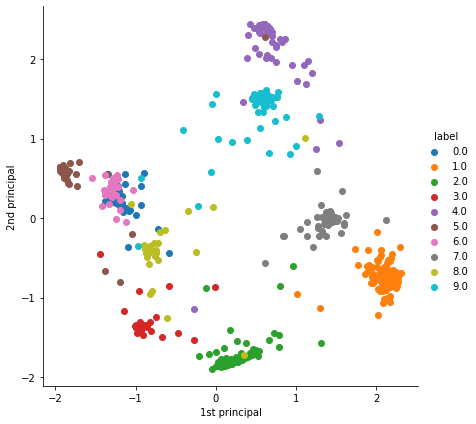

In [42]:
sns.FacetGrid(pca_df, hue='label',height=6).map(plt.scatter,'1st principal','2nd principal').add_legend()
plt.show()